In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "train/train" ,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 5657 files belonging to 5 classes.


In [4]:
class_name = dataset.class_names
print(class_name)
n_class = len(class_name)

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [5]:
len(dataset)

177

In [6]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[4 3 3 3 4 3 1 0 1 4 1 1 1 2 3 1 0 3 3 0 2 1 1 2 3 1 1 3 3 1 3 3]


2024-11-19 16:19:35.042416: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2024-11-19 16:19:35.848527: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


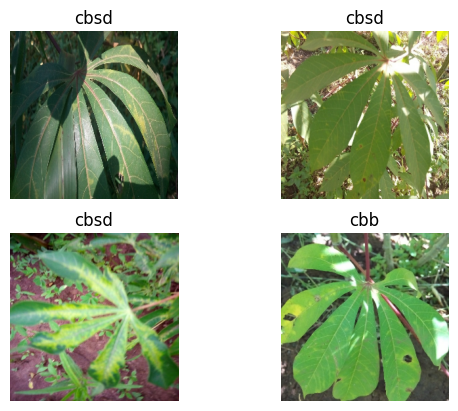

In [7]:
for img_batch, label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        print(img_batch[i].shape)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

## Spliting the data into train and test

In [8]:
train_size = 0.8
val_size = 0.1
n_train = int(train_size*len(dataset))
n_val = int(val_size*len(dataset))
print(n_train)
print(n_val)

141
17


In [9]:
train_ds = dataset.take(n_train)
test_ds = dataset.skip(n_train)
print(f'train size : {len(train_ds)}')
print(f'test size : {len(test_ds)}')

train size : 141
test size : 36


In [10]:
val_ds = test_ds.take(n_val)
test_ds = test_ds.skip(n_val)

In [11]:
def get_data_partitions_tf(ds, train_split = train_size, val_split=val_size,shuffle=True,shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    n_train = int(train_size*ds_size)
    n_val = int(val_size*ds_size)
    
    train_ds = ds.take(n_train)
    test_ds = ds.skip(n_train)

    val_ds = test_ds.take(n_val)
    test_ds = test_ds.skip(n_val)
    
    return train_ds, val_ds,test_ds

In [12]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [13]:
len(train_ds)

141

In [14]:
len(val_ds)

17

In [15]:
len(test_ds)

19

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Building Models

In [19]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = len(class_name)

In [20]:
tf.keras.applications.

<module 'keras.api.applications' from '/Users/BabouMbaye/PycharmProjects/EndToEndVison/.venv/lib/python3.12/site-packages/keras/api/applications/__init__.py'>

In [66]:
resnet_model = models.Sequential()

predtained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    pooling='avg',
    classes=n_class,
    weights='imagenet'
)

for layer in predtained_model.layers:
    layer.trainable=False

resnet_model.add(resize_and_rescale)
resnet_model.add(predtained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(64,activation='relu'))
resnet_model.add(layers.Dense(n_classes,activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


In [67]:
resnet_model.build(input_shape=input_shape)

In [68]:
resnet_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (32, 512)              │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,845 (56.26 MB)

 Trainable params: 33,157 (129.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [69]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = resnet_model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.4912 - loss: 1.2958 - val_accuracy: 0.6930 - val_loss: 0.8826
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.6489 - loss: 0.9285 - val_accuracy: 0.7059 - val_loss: 0.8179
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.6713 - loss: 0.8843 - val_accuracy: 0.7316 - val_loss: 0.7694
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.6906 - loss: 0.8515 - val_accuracy: 0.7463 - val_loss: 0.7370
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.7023 - loss: 0.8146 - val_accuracy: 0.7592 - val_loss: 0.7095
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.7093 - loss: 0.7802 - val_accuracy: 0.7592 - val_loss: 0.6897
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.7172 - loss: 0.7594 - val_accuracy: 0.7629 - val_loss: 0.6735
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.7237 - loss: 0.7543 - val_accu

In [71]:
scores = resnet_model.evaluate(test_ds)
scores

19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7443 - loss: 0.7051


[0.6943159699440002, 0.75]

In [72]:
history

In [73]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 141}

In [74]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

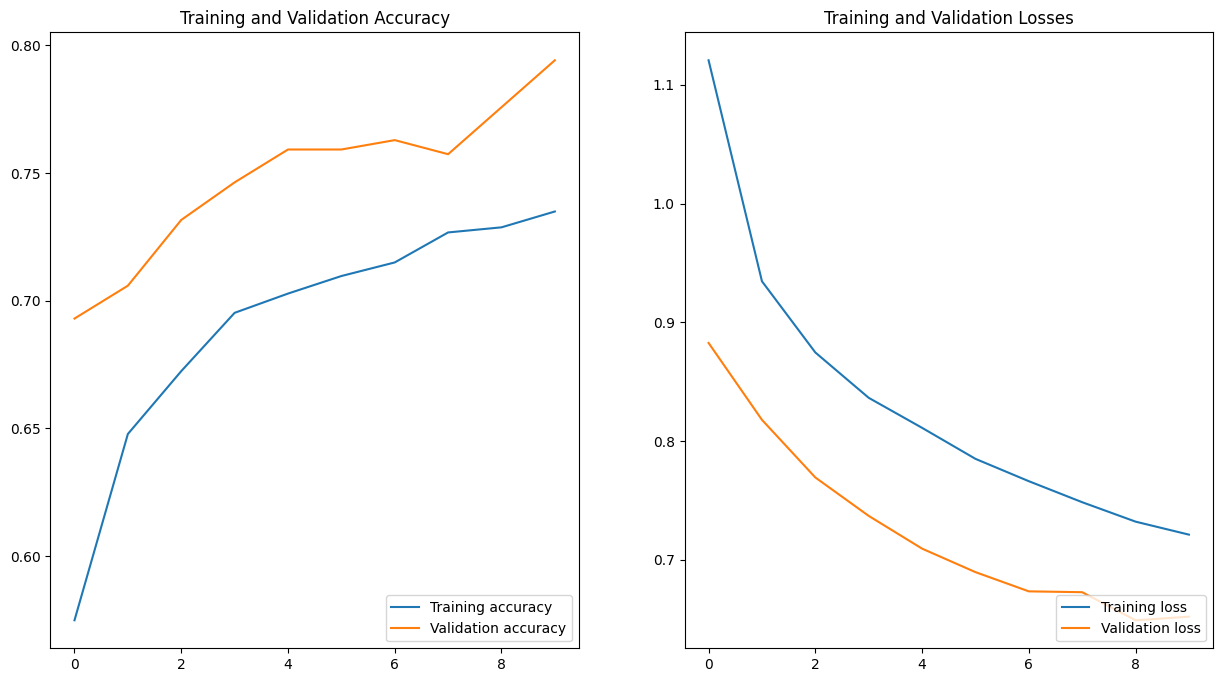

In [76]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label='Training accuracy')
plt.plot(range(10), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Losses')

2024-10-17 17:00:25.051553: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


first image to predict
actual label: cmd
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: cmd


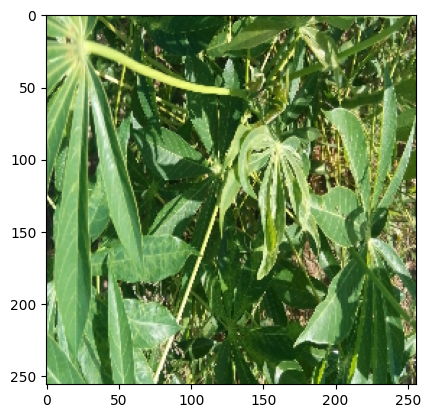

In [77]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

print("first image to predict")
plt.imshow(first_image)
print(f"actual label: {class_name[first_label]}")

batch_prediction = resnet_model.predict(image_batch)
print(f"Predicted label: {class_name[np.argmax(batch_prediction[0])]}")

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


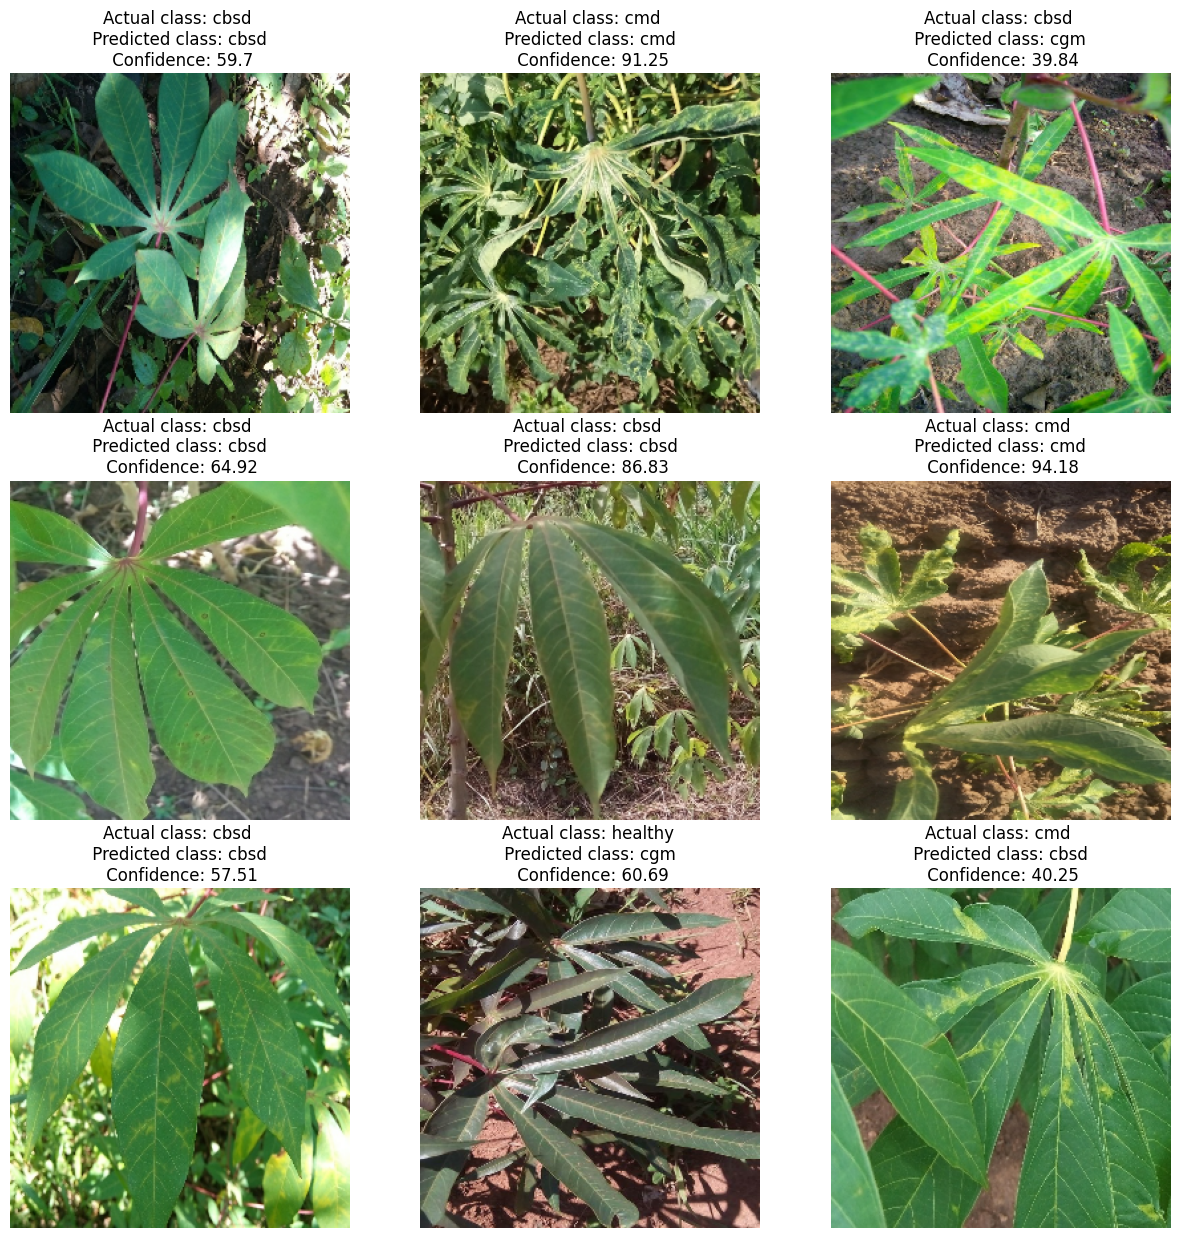

In [79]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f'Actual class: {actual_class} \n Predicted class: {predicted_class} \n Confidence: {confidence}' )
        plt.axis('off')
        

In [81]:
model_version = 'version_2'
resnet_model.save('saved_models/version_2.keras')
resnet_model.save('saved_models/version_2.h5')
resnet_model.export('saved_models/version_2')


INFO:tensorflow:Assets written to: saved_models/version_2/assets


INFO:tensorflow:Assets written to: saved_models/version_2/assets


Saved artifact at 'saved_models/version_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3485')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  13173079696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173079120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173074128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173077584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173077776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173073360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173074704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173072208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13173072592: TensorSpec(shape=(), dtype=tf.